# Recursive Green Function code - basic usage

In [1]:
from multiprocessing import Pool
import RGF_src as rgf
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('/home/simao/Notas/codes/tight-binding-test/src')
import band_structure as bs

# Example 1: 1D TB
The 1D tight-binding lattice can be obtained by using the 2D lattice of width 1 without periodic boundary conditions

In [2]:
# sample geometry
width=1
length=6

# Boundary conditions. Twist false means open boundary conditions. 
# k is only used when twist=True but it needs to exist
twist = False
k = 0

# set the Hamiltonian. ander is the strength of Anderson disorder
sys = rgf.rgf()
sys.set_2dtb_nanoribbon(width, length, twist, k, ander=0.0)



## Landauer

In [3]:
# list of complex energies
eta = 1e-5
NE = 200
energies = np.linspace(-4,4, NE)
zs = energies + eta*1j

land = sys.get_landauer(zs)

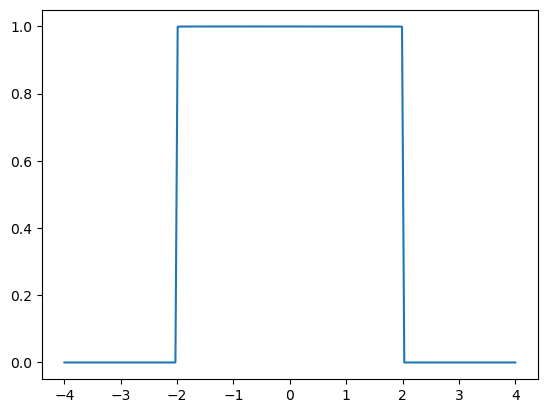

In [4]:
plt.plot(energies, np.real(land))
plt.show()

# Example 2: Graphene Hamiltonian with Rashba

In [5]:
# Hamiltonian paramters
t  = -1.0
λR = 0.3
Δx = 0.4

# Sample geometry
width=3
length=5

# Twist parameters
twist = False
k = 0.0 

# Output parameters
NE = 30
energies = np.linspace(-3.5,3.5, NE)
eta = 1e-5
zs = energies + 1j*eta
    
# Initialize the graphene + Rashba system implemented with the general TB functionality
model = rgf.rgf()
model.set_branislav(width, length, twist, k, t=t, λR=λR, λex=Δx)

# Get Landauer
land = np.real(model.get_landauer(zs))

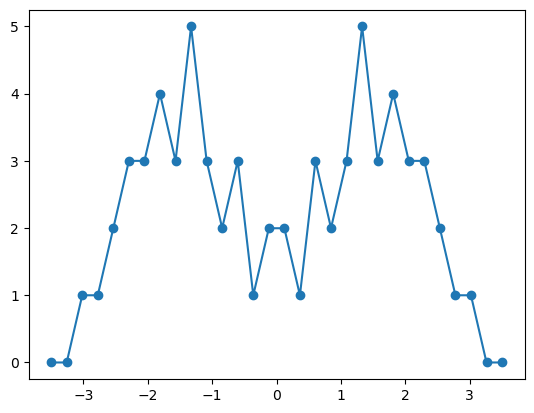

In [6]:
plt.plot(energies, land, '-o')
plt.show()

# Graphene Rashba + mag

In [43]:
width=6
length=3
twist = True
k = 0

λR = 0.4
λex = -0.4

# set the relevant quantities
gramag = rgf.rgf()
gramag.set_general_graphene_nanoribbon_rashba(width, length, twist, k, λex=λex, λR=λR)
gramag.build_spin()
gramag.build_vels_hsample()


# Open
gramagO = rgf.rgf()
gramagO.set_general_graphene_nanoribbon_rashba(width, length, False, k, λex=λex, λR=λR)
gramagO.build_spin()
gramagO.build_vels_hsample()


C  = gramag.C
S  = gramag.S
No = gramag.No


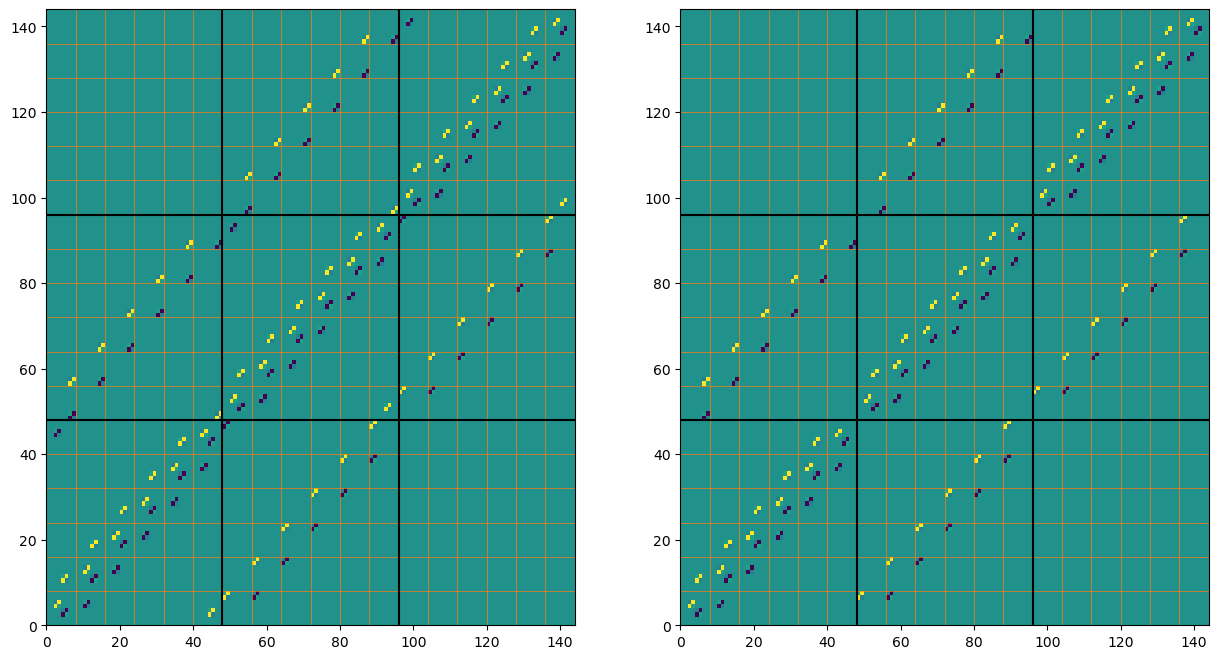

In [44]:
fig, axs = plt.subplots(1,2,figsize=(15,8))
axs[0].pcolormesh(np.real( gramag.vy*1j))
axs[1].pcolormesh(np.real(gramagO.vy*1j))

for ax in axs:
    # for i in range(1,25):
    #     axs.axvline(4*i-0.5, color='w', linewidth=0.6)
    #     axs.axhline(4*i-0.5, color='w', linewidth=0.6)
    
    for i in range(1,length*width):
        ax.axvline(No*i, color='C1', linewidth=0.5)
        ax.axhline(No*i, color='C1', linewidth=0.5)
    
    for i in range(1,length):
        ax.axvline(C*i, color='k')
        ax.axhline(C*i, color='k')
plt.show()

In [27]:


# list of complex energies
eta = 0.01
NE = 200
energies = np.linspace(-4.1,4.1, NE)
zs = energies + eta*1j

n = 2
mat = gramag.get_Gnn(zs, n)
dos = zs*0.0
for i in range(C):
    dos += mat[i,i]

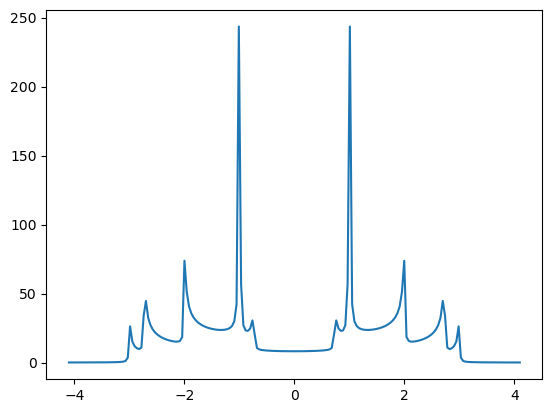

In [28]:
dos = -np.imag(dos)
plt.plot(energies, dos)
plt.show()

In [45]:
dic = gramag.orbs_dic

orbs = []
poss = []
for orb in dic.keys():
    i = dic[orb]
    r = gramag.pos[i]
    # print(orb, i, r)
    orbs.append(orb)
    poss.append(r)

nocc_hops = bs.remove_cc(gramag.hops)
    
# Reorder the hoppings into a format that band_structure.py can read
reordered_hops = []
for hop in nocc_hops:
    fro, to, i0, i1, value = hop    
    reordered = [[i0,i1], fro, to, value]
    reordered_hops.append(reordered)    
    # print(hop, reordered)

GR = bs.band_structure()
GR.DEBUG = 0 # Debug flag. Set to 1 to get debug information

# Lattice properties and primitive vectors (already defined reciprocal lattice vectors)
GR.set_primitive2(gramag.prim[0],gramag.prim[1])

# Information about the orbitals
GR.set_orbs(orbs, poss)

# Information about the hoppings for the tight-binding model
GR.set_bonds(reordered_hops)



In [40]:

a_cc = 1.0
a = np.sqrt(3)

# Primitive vectors
a1 = a*np.array([np.sqrt(3)/2, 0.5])
a2 = a*np.array([0,1])

# Rec lattice primitive vector
b1 = np.pi*4/np.sqrt(3)/a*np.array([1, 0])
b2 = np.pi*4/np.sqrt(3)/a*np.array([-0.5, np.sqrt(3)/2])

for i in [a1, a2]:
    for j in [b1, b2]:
        print(i@j/np.pi/2, end=" ")

A1, A2 = gramag.prim
B1 = np.array([A2[1], -A2[0]])
B2 = np.array([A1[1], -A1[0]])
print(A1, A2)

B1 = B1/(B1@A1)*np.pi*2
B2 = B2/(B2@A2)*np.pi*2


for i in [A1, A2]:
    for j in [B1, B2]:
        print(i@j/np.pi/2, end=" ")


1.0 0.0 0.0 1.0 [3. 0.] [0.         1.73205081]
1.0 0.0 0.0 0.9999999999999999 

In [35]:
all_vals = []
NKX = 200; dkx = 1/NKX
# NKY = 6;   dky = 1/NKY
NKY = 200;   dky = 1/NKY
kx_list = np.array([i*dkx for i in range(NKX)])
ky_list = np.array([i*dky for i in range(NKY)])

for i,kx in enumerate(kx_list):
    print(i, end=" ")
    for j,ky in enumerate(ky_list):
        k = np.array([kx,ky])
        Hk = GR.get_Hk(k)
        
        vals = np.linalg.eigvalsh(Hk)
        for val in vals:
            all_vals.append(val)

NK = NKX*NKY

dosk = zs*0.0
for val in all_vals:
    dosk += 1.0/(zs-val)
dosk = np.imag(dosk)/NK

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 

KeyboardInterrupt: 

In [ ]:
plt.plot(energies, -dosk*width, label="K-space")
plt.axvline(λR*2, color='k', linestyle='--')
# plt.plot(energies, dos, label="RGF")
plt.legend()
plt.show()

In [46]:

K  = np.array([1.0/3.0, 2.0/3.0])
Kp = np.array([2.0/3.0, 1.0/3.0])
M  = np.array([0.5, 0.5])
Γ  = np.array([0,0])

points = [K,Kp,M,Γ]
pointsB = []
for P in points:
    kvec = P[0]*b1 + P[1]*b2
    KB = np.array([kvec@A1/np.pi/2, kvec@A2/np.pi/2])
    pointsB.append(KB.copy())
    # print(kvec)
    # print(KB)


for p,pb in zip(points, pointsB):
    print(p,pb)

KB, KpB, MB, ΓB = pointsB
KpB[0] -= 1 

[0.33333333 0.66666667] [0.         0.66666667]
[0.66666667 0.33333333] [1.         0.33333333]
[0.5 0.5] [0.5 0.5]
[0 0] [0. 0.]


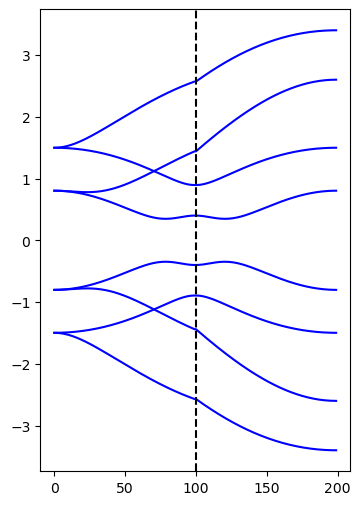

In [47]:
# Plot band structure
GR.set_kpath([MB,KpB,ΓB],100)

fig, axs = plt.subplots(figsize=(4,6))
bands = GR.get_bands()

for i in range(GR.N_orbs):
    b = bands[:,i]
    axs.plot(b,c='b')

axs.axvline(100, linestyle='--', color='k')
plt.show()